# Taller 3
### Oscar Mejia 
### 201516790
**** 

In [240]:

%pylab inline
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import string
import matplotlib.cm as cm
import os
from scipy import ndimage
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


In [241]:
#Datos generales del carro
masa=152.0 # masa del Kart (kg)
ng=3.4 # Relación de Transmisión
a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)
mu_c=1 #coeficiente de adherencia de las ruedas
# Datos Llantas tractivas 
rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)

# Datos Transmisión
#dp=11.0 # Dientes del piñon
#dpl=39.0 # Dientes del plato
#ng=dpl/dp # Relación de Transmisión
ng=1.9
etaf=0.95 # Eficiencia de transmisión

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
#masa=152.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=5.2E-3 # Inercia motor de combustión (kg m^2) 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)
illTotal=2*illd+illt*2
#paso=7.62 #(mm)
#rpim= paso*(0.6+(1/tan(180/dp))) # Radio Piñon (mm)
#rplam=paso*(0.6+(1/tan(180/dpl))) # Radio Plato (mm)
#rpi= rpim/1000 #Radio Piñon (m)
#rpla= rplam/1000 #Radio Plato (m)
rpi=0.01525#(m)
rpla=0.04096 #(m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.02 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)

# Fuerzas Aceleración
# Resistencia a la rodadura
#a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
#l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
#h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)
masaEquivalente=((illTotal)+(ieje)+(ii*ng**2))/refc**2


In [242]:
def arrastre(Vx):
    return (1/2)*(rho)*af*cd*(Vx+0)**2

In [243]:
def rodadura(vx,ax):
    wr=w*((a/l)+(ax/g*(h/l))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    return wr*fr*cos(theta)

In [244]:
def TorqueMotor(a_i,v_i):
    T=(masa+masaEquivalente)*a_i+rodadura(v_i,a_i)+arrastre(v_i)
    T=T*refc/(ng-etaf)
    if T<0:
        T=0
    return T

In [245]:
def VelocidadAngular(vx):
    a=(vx*ng)/refc
    a=(vx*ng)/refc
    if a<50*(2*np.pi)/60:
        a=50*(2*np.pi)/60
    if a>5000*(2*np.pi)/60:
        a=5000*(2*np.pi)/60 
    return a # (rad/s)

In [246]:
def derivacionNum(vector,tiempo):
    acel=[]
    dt = tiempo[1]-tiempo[0]
    for i,v in enumerate (vector):
            if i<len(vector)-1:
                a=(vector[i+1]-vector[i])/dt
                acel.append(a)
    return acel            

In [247]:
def filtroMapaCombustion(lat):
    res=[]
    inicio=15690
    puntos=5570+8
    fin=inicio+puntos
    for i,v in enumerate (lat):
            if i>=inicio:  
               if i<=fin:
                 res.append(v)
    return np.asarray(res)        

In [279]:
def filtroMapaElectrico(lat):
    res=[]
    inicio=7900+65/0.05
    puntos=2800
    fin=inicio+puntos
    for i,v in enumerate (lat):
            if i>=inicio:  
               if i<=fin:
                    res.append(v)
    return np.asarray(res)

In [280]:
def importarDatos(TipoKart):
    if TipoKart=="electrico":
        base_dir = os.path.join('.','Data')
        data_file = 'VBS__052.VBO'
        with open(os.path.join(base_dir,data_file), 'r') as vboxdata:
            sats = []
            time = []
            lat = []
            long = []
            vel = []
            height = []
            #acel_e=[]
            vertv = []
            torque=[]
            v_angular=[]
            for line in vboxdata:
                if line[0] == '[':
                    sats= str.replace(line, "\n","")
                    continue
                if  sats == '[column names]':
                    col_names = str.replace(line, "  \n","").split('  ')
                    sats = []
                if  sats == '[data]':
                    linesplit = str.replace(line, " \n","").split(' ')
                    time.append(float(linesplit[1][0:2])*3600+float(linesplit[1][2:4])*60+float(linesplit[1][4:]))
                    lat.append(float(linesplit[2]))
                    long.append(float(linesplit[3]))
                    vel.append(float(linesplit[4]))
                    height.append(float(linesplit[6]))
                    #vertv.append(float(linesplit[7]))
        
        #print(len(long),len(lat))
        time_e = np.asarray(time)
        print(len(time_e))
        time_e = filtroMapaElectrico(time_e)
        
        lat_e = np.asarray(lat)
        lat_e=filtroMapaElectrico(lat_e)
        
        long_e = np.asarray(long)
        long_e=filtroMapaElectrico(long_e)
        
        vel_e = np.asarray(vel)
        vel_e=filtroMapaElectrico(vel_e)*1000/3600  
        
        #height = np.asarray(height)
        #vertv = np.asarray(vertv)
        print(time_e)
        time_base = time_e[0]
        time_e = time_e - time_base
        lat_e = lat_e/60.0
        long_e = long_e/60.0
        dt = time_e[1]-time_e[0]
        print(dt)
        acel_e=derivacionNum(vel_e,time_e)
        for i,a in enumerate(acel_e):
            torque.append(TorqueMotor(acel_e[i],vel_e[i]))
            v_angular.append(VelocidadAngular(vel_e[i]))
                
        fig = plt.figure()
        ax = Axes3D(fig)
        plt.plot(long_e,lat_e,time_e)
        plt.figure()
        plt.plot(long_e,lat_e)
        plt.figure()
        plt.plot(time_e,vel_e)
        plt.figure()
        plt.plot(torque,'*')
        plt.xlabel('Velocidad ')
        plt.ylabel('Torque')
      
        
    if TipoKart=="combustion":
        base_dir = os.path.join('.','Data')
        data_file = 'VBOX0019.VBO'
        print(data_file)
        with open(os.path.join(base_dir,data_file), 'r') as vboxdata:
            section = []
            time = []
            lat = []
            long = []
            vel = []
            height_c = []
            vertv = []
            torque=[]
            v_angular=[]
            for line in vboxdata:
                if line[0] == '[':
                    section = str.replace(line, "\n","")
                    continue
                if section == '[column names]':
                    col_names = str.replace(line, "  \n","").split('  ')
                    section = []
                if section == '[data]':
                    linesplit = str.replace(line, " \n","").split(' ')
                    time.append(float(linesplit[1][0:2])*3600+float(linesplit[1][2:4])*60+float(linesplit[1][4:]))
                    lat.append(float(linesplit[2]))
                    long.append(float(linesplit[3]))
                    vel.append(float(linesplit[4]))
                    height_c.append(float(linesplit[6]))
                    vertv.append(float(linesplit[7]))

        time_c = np.asarray(time)
        
        time_c=filtroMapaCombustion(time_c)        
        
        lat_c = np.asarray(lat)
        lat_c=filtroMapaCombustion(lat_c)
        long_c = np.asarray(long)
        long_c=filtroMapaCombustion(long_c)
        vel_c = np.asarray(vel)
        vel_c=filtroMapaCombustion(vel_c)*1000/3600
        
        height_c = np.asarray(height_c)
        #vertv = np.asarray(vertv)
        time_base = time_c[0]
        time_c = time_c - time_base
        lat_c = lat_c/60.0
        long_c = long_c/60.0
        dt = time_c[1]-time_c[0]
        
        acel_c=derivacionNum(vel_c,time_c)
        for i,a in enumerate(acel_c):
            torque.append(TorqueMotor(acel_c[i],vel_c[i]))
            v_angular.append(VelocidadAngular(vel_c[i]))
                
        fig = plt.figure()
        ax = Axes3D(fig)
        plt.plot(long_c,lat_c,time_c)
        plt.figure()
        plt.plot(time_c,vel_c)
        plt.figure()
        plt.plot(long_c,lat_c)
        plt.figure()
        plt.plot(torque,'*')
        plt.xlabel('Velocidad ')
        plt.ylabel('Torque')
       
   

VBOX0019.VBO


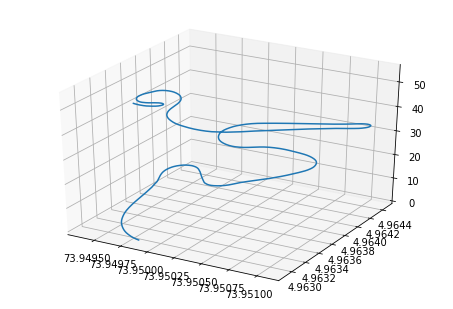

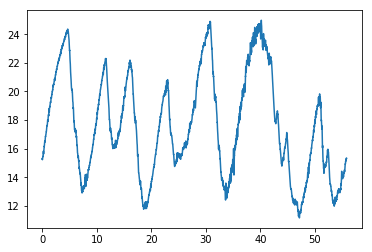

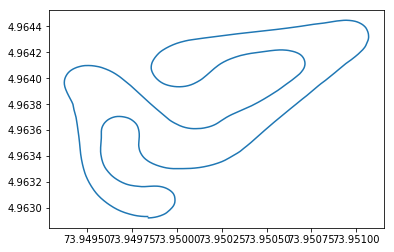

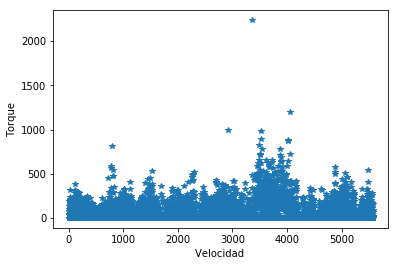

In [281]:
importarDatos("combustion")

13893
[76264.05 76264.1  76264.15 ... 76421.8  76421.85 76421.9 ]
0.05000000000291038


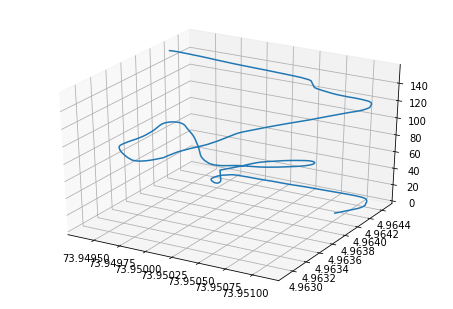

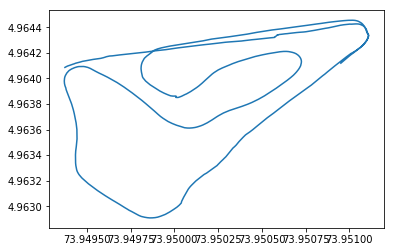

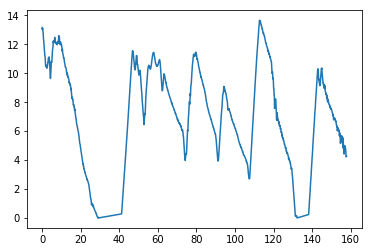

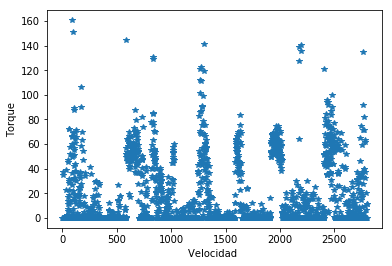

In [282]:
importarDatos("electrico")

In [276]:
20/0.05

400.0